## 1. Setup and Imports

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json
import os

warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('Set2')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [2]:
# Import custom modules
import sys
sys.path.append('..')

from src.features.aggregation import create_aggregation_features
from src.features.interactions import create_interaction_features
from src.features.temporal import create_temporal_features
from src.features.missing_features import create_missing_value_features
from src.models.lgbm_baseline import LGBMBaseline
from src.models.ensemble import ModelEnsemble, simple_blend, rank_average
from src.utils import (
    plot_roc_curve,
    plot_feature_importance,
    evaluate_model,
    print_evaluation_metrics,
    reduce_mem_usage
)

print("✓ Custom modules imported successfully")

✓ Custom modules imported successfully


## 2. Load Data

In [3]:
# Load data
print("Loading data...\n")

train_transaction = pd.read_csv('../data/train_transaction.csv')
train_identity = pd.read_csv('../data/train_identity.csv')

print(f"Train transaction shape: {train_transaction.shape}")
print(f"Train identity shape: {train_identity.shape}")

# Merge datasets
train_df = train_transaction.merge(train_identity, on='TransactionID', how='left')
print(f"\nMerged train shape: {train_df.shape}")
print(f"Fraud rate: {train_df['isFraud'].mean()*100:.2f}%")

# Reduce memory
train_df = reduce_mem_usage(train_df)

print("\n✓ Data loaded successfully")

Loading data...

Train transaction shape: (590540, 394)
Train identity shape: (144233, 41)
Train transaction shape: (590540, 394)
Train identity shape: (144233, 41)

Merged train shape: (590540, 434)
Fraud rate: 3.50%

Merged train shape: (590540, 434)
Fraud rate: 3.50%
Memory usage decreased from 1955.37 MB to 1044.70 MB (46.6% reduction)

✓ Data loaded successfully
Memory usage decreased from 1955.37 MB to 1044.70 MB (46.6% reduction)

✓ Data loaded successfully


## 3. Create All Features

In [4]:
# Create all features from previous milestones
print("Creating all features...\n")

# Missing value features
train_df, missing_feature_names = create_missing_value_features(train_df)
print(f"✓ Created {len(missing_feature_names)} missing value features")

# Aggregation features
train_df, agg_feature_names = create_aggregation_features(train_df, target_col='TransactionAmt')
print(f"✓ Created {len(agg_feature_names)} aggregation features")

# Interaction features
train_df, interaction_feature_names = create_interaction_features(train_df, min_samples=10)
print(f"✓ Created {len(interaction_feature_names)} interaction features")

# Temporal features
train_df, temporal_feature_names = create_temporal_features(train_df, include_velocity=False)
print(f"✓ Created {len(temporal_feature_names)} temporal features")

print(f"\nFinal shape: {train_df.shape}")

Creating all features...


CREATING MISSING VALUE FEATURES

Creating basic missing value indicators...
  Creating indicators for 322 columns with >5% missing
  Created 52 basic missing indicators
Creating group-level missing features...
  Creating indicators for 322 columns with >5% missing
  Created 52 basic missing indicators
Creating group-level missing features...
  Created 20 group missing features
Creating missing value co-occurrence features...
  Created 20 group missing features
Creating missing value co-occurrence features...
  Created 12 co-occurrence features
Creating card-related missing pattern features...
  Created 12 co-occurrence features
Creating card-related missing pattern features...
  Created 8 card missing features
Creating unusual missing pattern features...
  Created 8 card missing features
Creating unusual missing pattern features...
  Created 8 unusual pattern features
Creating missing value interaction features...
  Created 8 unusual pattern features
Creating

## 4. Load Selected Features (from M12)

In [5]:
# Load selected features from feature selection
try:
    with open('../models/selected_features.json', 'r') as f:
        selected_info = json.load(f)
    
    selected_features = selected_info['features']
    print(f"✓ Loaded {len(selected_features)} selected features from M12")
    print(f"  Original AUC improvement: {selected_info['improvement']:.6f}")
except:
    # Fallback: use all features
    selected_features = None
    print("Note: Using all features (M12 feature selection not found)")

✓ Loaded 286 selected features from M12
  Original AUC improvement: -0.000974


## 5. Prepare Data

In [6]:
# Prepare features
print("Preparing data for modeling...\n")

# Separate target
y = train_df['isFraud']
X = train_df.drop(['isFraud', 'TransactionID'], axis=1)

# Use selected features if available
if selected_features is not None:
    available_features = [f for f in selected_features if f in X.columns]
    X = X[available_features]
    print(f"Using {len(available_features)} selected features")
else:
    print(f"Using all {X.shape[1]} features")

# Encode categorical features
from sklearn.preprocessing import LabelEncoder

categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Encoding {len(categorical_features)} categorical features...")

for col in categorical_features:
    le = LabelEncoder()
    X[col] = X[col].astype(str).replace('nan', 'missing')
    X[col] = le.fit_transform(X[col])

# Fill missing values
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
for col in numeric_features:
    if X[col].isnull().any():
        X[col] = X[col].fillna(X[col].median())

print(f"\n✓ Final feature count: {X.shape[1]}")
print("✓ Data preparation complete")

Preparing data for modeling...

Using 286 selected features
Encoding 19 categorical features...
Using 286 selected features
Encoding 19 categorical features...

✓ Final feature count: 286
✓ Data preparation complete

✓ Final feature count: 286
✓ Data preparation complete


## 6. Train/Validation Split

In [7]:
# Time-based split
print("Creating time-based train/validation split...\n")

split_point = int(len(X) * 0.8)

X_train = X.iloc[:split_point]
X_val = X.iloc[split_point:]
y_train = y.iloc[:split_point]
y_val = y.iloc[split_point:]

print(f"Training set: {X_train.shape[0]:,} samples, fraud rate: {y_train.mean()*100:.2f}%")
print(f"Validation set: {X_val.shape[0]:,} samples, fraud rate: {y_val.mean()*100:.2f}%")
print(f"Features: {X_train.shape[1]}")
print("\n✓ Data split complete")

Creating time-based train/validation split...

Training set: 472,432 samples, fraud rate: 3.51%
Validation set: 118,108 samples, fraud rate: 3.44%
Features: 286

✓ Data split complete


## 7. Single Model Baseline

In [8]:
# Train single LightGBM model as baseline
print("Training single LightGBM model (baseline)...\n")

# Load best params from M11
try:
    with open('../models/staged_tuned_params.json', 'r') as f:
        best_params = json.load(f)
    print("✓ Loaded tuned parameters from M11")
except:
    best_params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'learning_rate': 0.01,
        'num_leaves': 256,
        'max_depth': 12,
        'min_child_samples': 50,
        'subsample': 0.9,
        'subsample_freq': 1,
        'colsample_bytree': 0.7,
        'reg_alpha': 0.5,
        'reg_lambda': 0.5,
        'n_jobs': -1,
        'random_state': 42,
        'verbose': -1
    }

baseline_model = LGBMBaseline(params=best_params)
baseline_metrics = baseline_model.train(
    X_train, y_train,
    X_val, y_val,
    num_boost_round=2000,
    early_stopping_rounds=100,
    verbose_eval=100
)

baseline_auc = baseline_metrics['val_auc']

print(f"\n{'='*70}")
print(f"SINGLE MODEL BASELINE")
print(f"{'='*70}")
print(f"Validation AUC: {baseline_auc:.6f}")
print(f"Training AUC: {baseline_metrics['train_auc']:.6f}")
print(f"{'='*70}")

Training single LightGBM model (baseline)...

✓ Loaded tuned parameters from M11
TRAINING LIGHTGBM BASELINE MODEL

Training samples: 472,432
Validation samples: 118,108
Features: 286

Training fraud rate: 3.51%
Validation fraud rate: 3.44%

Training model...
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.992554	valid's auc: 0.979374
[100]	train's auc: 0.992554	valid's auc: 0.979374
[200]	train's auc: 0.995516	valid's auc: 0.981274
[200]	train's auc: 0.995516	valid's auc: 0.981274
[300]	train's auc: 0.997433	valid's auc: 0.982311
[300]	train's auc: 0.997433	valid's auc: 0.982311
[400]	train's auc: 0.998482	valid's auc: 0.982633
[400]	train's auc: 0.998482	valid's auc: 0.982633
[500]	train's auc: 0.999156	valid's auc: 0.982607
[500]	train's auc: 0.999156	valid's auc: 0.982607
Early stopping, best iteration is:
[417]	train's auc: 0.998612	valid's auc: 0.982679
Early stopping, best iteration i

## 8. Build Ensemble with Multiple Models

In [9]:
# Create ensemble with diverse models
print("Building ensemble with multiple models...\n")

ensemble = ModelEnsemble(verbose=True)

# Model 1: LightGBM with original params
lgb_params_1 = best_params.copy()
lgb_params_1['random_state'] = 42
ensemble.add_lightgbm(lgb_params_1, name='LightGBM_1')

# Model 2: LightGBM with different hyperparameters (more conservative)
lgb_params_2 = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.005,  # Lower learning rate
    'num_leaves': 128,        # Fewer leaves
    'max_depth': 10,          # Shallower
    'min_child_samples': 100, # More conservative
    'subsample': 0.8,
    'subsample_freq': 1,
    'colsample_bytree': 0.8,
    'reg_alpha': 1.0,         # More regularization
    'reg_lambda': 1.0,
    'verbose': -1,
    'random_state': 123,
    'n_jobs': -1
}
ensemble.add_lightgbm(lgb_params_2, name='LightGBM_2')

# Model 3: LightGBM with different hyperparameters (more aggressive)
lgb_params_3 = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.02,    # Higher learning rate
    'num_leaves': 384,         # More leaves
    'max_depth': 14,           # Deeper
    'min_child_samples': 30,   # Less conservative
    'subsample': 0.85,
    'subsample_freq': 1,
    'colsample_bytree': 0.6,
    'reg_alpha': 0.3,
    'reg_lambda': 0.3,
    'verbose': -1,
    'random_state': 456,
    'n_jobs': -1
}
ensemble.add_lightgbm(lgb_params_3, name='LightGBM_3')

# Try to add XGBoost and CatBoost if available
try:
    import xgboost as xgb
    xgb_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'tree_method': 'hist',
        'learning_rate': 0.01,
        'max_depth': 10,
        'min_child_weight': 50,
        'subsample': 0.85,
        'colsample_bytree': 0.8,
        'reg_alpha': 0.5,
        'reg_lambda': 0.5,
        'random_state': 42,
        'n_jobs': -1
    }
    ensemble.add_xgboost(xgb_params, name='XGBoost')
except:
    print("Note: XGBoost not available")

try:
    import catboost as cb
    cb_params = {
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'learning_rate': 0.01,
        'depth': 8,
        'l2_leaf_reg': 3,
        'subsample': 0.85,
        'random_state': 42,
        'verbose': False,
        'thread_count': -1
    }
    ensemble.add_catboost(cb_params, name='CatBoost')
except:
    print("Note: CatBoost not available")

print(f"\n✓ Ensemble configured with {len(ensemble.base_models)} models")

Building ensemble with multiple models...

✓ Added LightGBM_1 to ensemble
✓ Added LightGBM_2 to ensemble
✓ Added LightGBM_3 to ensemble
✓ Added XGBoost to ensemble
✓ Added CatBoost to ensemble

✓ Ensemble configured with 5 models


## 9. Train Ensemble with Stacking

In [10]:
# Train ensemble with 5-fold stacking
print("Training ensemble with stacking (this may take 30-60 minutes)...\n")

stacking_results = ensemble.fit_stacking(
    X_train, y_train,
    n_folds=5,
    num_boost_round=2000,
    early_stopping_rounds=100,
    stratified=True
)

ensemble_oof_score = stacking_results['ensemble_score']

print(f"\n{'='*70}")
print(f"STACKING ENSEMBLE RESULTS")
print(f"{'='*70}")
print(f"Ensemble OOF AUC: {ensemble_oof_score:.6f}")
print(f"Single model baseline: {baseline_auc:.6f}")
print(f"Improvement: {ensemble_oof_score - baseline_auc:+.6f}")
print(f"{'='*70}")

Training ensemble with stacking (this may take 30-60 minutes)...

STACKING ENSEMBLE

Training 5 base models with 5-fold CV...

----------------------------------------------------------------------
Training LightGBM_1
----------------------------------------------------------------------
  Fold 1/5... AUC: 0.991089
  Fold 2/5... AUC: 0.991089
  Fold 2/5... AUC: 0.991113
  Fold 3/5... AUC: 0.991113
  Fold 3/5... AUC: 0.991967
  Fold 4/5... AUC: 0.991967
  Fold 4/5... AUC: 0.992442
  Fold 5/5... AUC: 0.992442
  Fold 5/5... AUC: 0.991782
  LightGBM_1 CV Score: 0.991678 ± 0.000519

----------------------------------------------------------------------
Training LightGBM_2
----------------------------------------------------------------------
  Fold 1/5... AUC: 0.991782
  LightGBM_1 CV Score: 0.991678 ± 0.000519

----------------------------------------------------------------------
Training LightGBM_2
----------------------------------------------------------------------
  Fold 1/5... AUC: 

## 10. Visualize Base Model Predictions

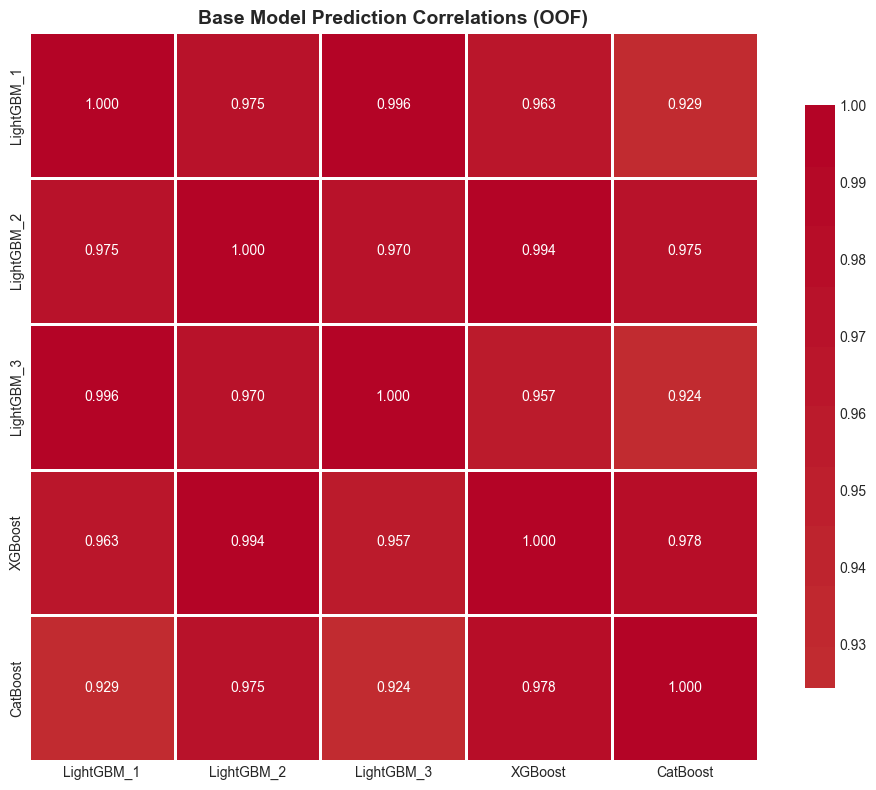


Base Model Prediction Statistics:
LightGBM_1      Mean: 0.0307  Std: 0.1588
LightGBM_2      Mean: 0.0341  Std: 0.1479
LightGBM_3      Mean: 0.0295  Std: 0.1591
XGBoost         Mean: 0.0348  Std: 0.1475
CatBoost        Mean: 0.0348  Std: 0.1395


In [11]:
# Visualize OOF predictions correlation
oof_df = pd.DataFrame(
    ensemble.oof_predictions,
    columns=[m['name'] for m in ensemble.base_models]
)

# Correlation heatmap
fig, ax = plt.subplots(figsize=(10, 8))
corr = oof_df.corr()
sns.heatmap(corr, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title('Base Model Prediction Correlations (OOF)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nBase Model Prediction Statistics:")
print("="*70)
for col in oof_df.columns:
    print(f"{col:15s} Mean: {oof_df[col].mean():.4f}  Std: {oof_df[col].std():.4f}")
print("="*70)

## 11. Optimize Ensemble Weights

In [12]:
# Optimize weights for ensemble
optimal_weights = ensemble.optimize_weights(y_train, method='grid')

# Get predictions with optimized weights
ensemble_val_pred_avg = ensemble.predict(X_val, use_meta_learner=False)
ensemble_val_pred_weighted = ensemble.predict_weighted(X_val)

# Calculate scores
from sklearn.metrics import roc_auc_score
auc_avg = roc_auc_score(y_val, ensemble_val_pred_avg)
auc_weighted = roc_auc_score(y_val, ensemble_val_pred_weighted)

print(f"\n{'='*70}")
print(f"ENSEMBLE WEIGHTING RESULTS")
print(f"{'='*70}")
print(f"Simple average:     {auc_avg:.6f}")
print(f"Weighted ensemble:  {auc_weighted:.6f}")
print(f"Improvement:        {auc_weighted - auc_avg:+.6f}")
print(f"{'='*70}")


Optimizing ensemble weights...
✓ Optimal weights found
  Weights: ['0.200', '0.200', '0.200', '0.200', '0.200']
  Weighted score: 0.988819

ENSEMBLE WEIGHTING RESULTS
Simple average:     0.982304
Weighted ensemble:  0.982304
Improvement:        +0.000000

ENSEMBLE WEIGHTING RESULTS
Simple average:     0.982304
Weighted ensemble:  0.982304
Improvement:        +0.000000


## 12. Train Meta-Learner

In [13]:
# Train meta-learner on OOF predictions
from sklearn.linear_model import LogisticRegression

meta_model = LogisticRegression(random_state=42, max_iter=1000, C=1.0)
meta_score = ensemble.fit_meta_learner(y_train, meta_model=meta_model)

# Get meta-learner predictions
ensemble_val_pred_meta = ensemble.predict(X_val, use_meta_learner=True)
auc_meta = roc_auc_score(y_val, ensemble_val_pred_meta)

print(f"\n{'='*70}")
print(f"META-LEARNER RESULTS")
print(f"{'='*70}")
print(f"Meta-learner validation AUC: {auc_meta:.6f}")
print(f"Simple average:              {auc_avg:.6f}")
print(f"Weighted ensemble:           {auc_weighted:.6f}")
print(f"Best improvement:            {max(auc_meta - baseline_auc, auc_weighted - baseline_auc):+.6f}")
print(f"{'='*70}")


Training meta-learner...
✓ Meta-learner trained
  Meta-learner score: 0.985493
✓ Meta-learner trained
  Meta-learner score: 0.985493

META-LEARNER RESULTS
Meta-learner validation AUC: 0.964691
Simple average:              0.982304
Weighted ensemble:           0.982304
Best improvement:            -0.000374

META-LEARNER RESULTS
Meta-learner validation AUC: 0.964691
Simple average:              0.982304
Weighted ensemble:           0.982304
Best improvement:            -0.000374


## 13. Performance Comparison

COMPREHENSIVE PERFORMANCE COMPARISON

Single Model Baseline:          0.982679
Ensemble (simple average):      0.982304  (+-0.000374)
Ensemble (optimized weights):   0.982304  (+-0.000374)
Ensemble (meta-learner):        0.964691  (+-0.017988)

Best ensemble AUC:              0.982304
Improvement over single model:  +-0.000374

Target (Top 10%):               0.945000
Gap to target:                  -0.037304


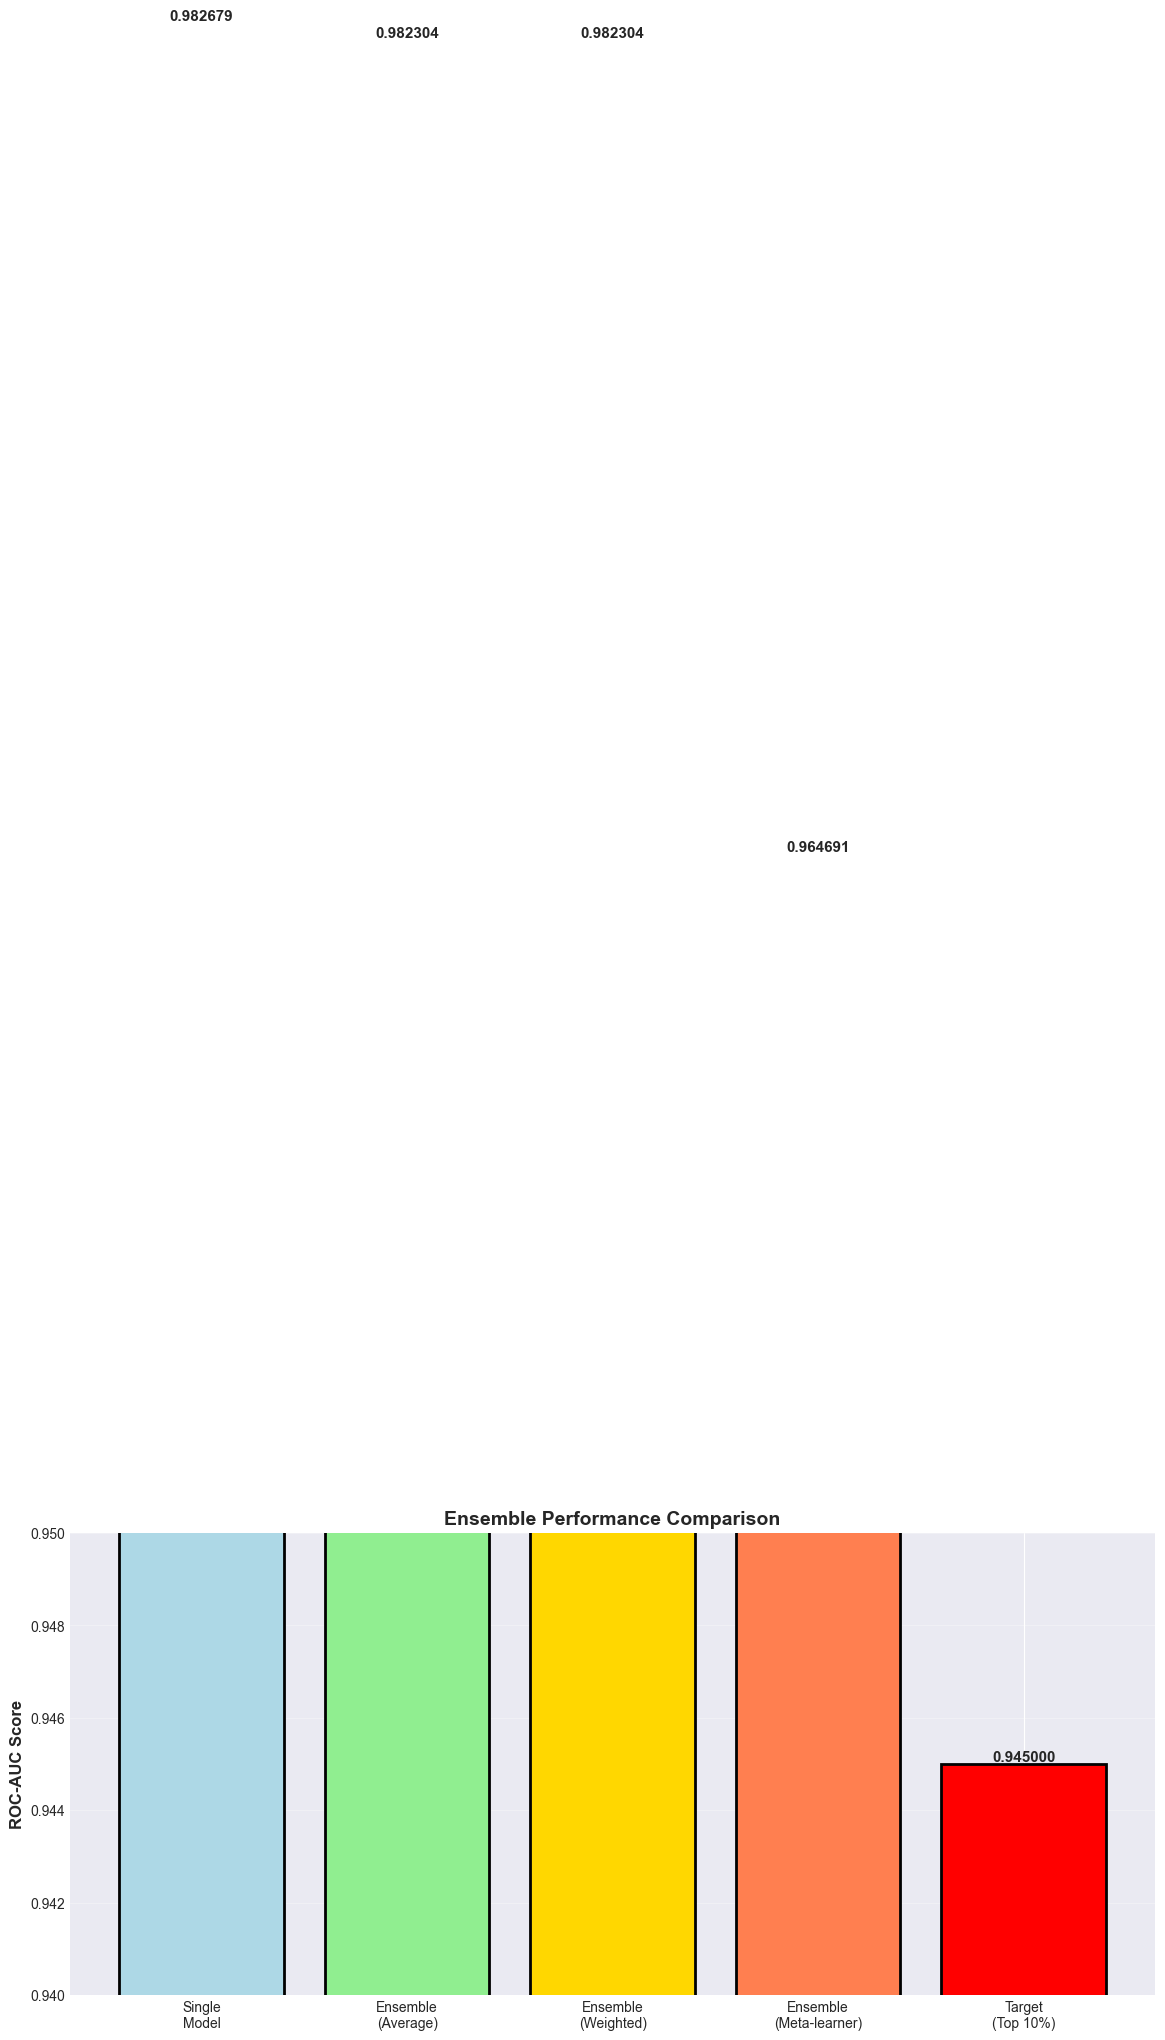

In [14]:
# Compare all approaches
print("="*70)
print("COMPREHENSIVE PERFORMANCE COMPARISON")
print("="*70)

print(f"\nSingle Model Baseline:          {baseline_auc:.6f}")
print(f"Ensemble (simple average):      {auc_avg:.6f}  (+{auc_avg - baseline_auc:.6f})")
print(f"Ensemble (optimized weights):   {auc_weighted:.6f}  (+{auc_weighted - baseline_auc:.6f})")
print(f"Ensemble (meta-learner):        {auc_meta:.6f}  (+{auc_meta - baseline_auc:.6f})")

best_auc = max(auc_avg, auc_weighted, auc_meta)
print(f"\nBest ensemble AUC:              {best_auc:.6f}")
print(f"Improvement over single model:  +{best_auc - baseline_auc:.6f}")

print(f"\nTarget (Top 10%):               0.945000")
print(f"Gap to target:                  {0.945 - best_auc:.6f}")
print("="*70)

# Visualization
fig, ax = plt.subplots(figsize=(14, 6))

models = ['Single\nModel', 'Ensemble\n(Average)', 'Ensemble\n(Weighted)', 'Ensemble\n(Meta-learner)', 'Target\n(Top 10%)']
scores = [baseline_auc, auc_avg, auc_weighted, auc_meta, 0.945]
colors = ['lightblue', 'lightgreen', 'gold', 'coral', 'red']

bars = ax.bar(models, scores, color=colors, edgecolor='black', linewidth=2)

# Add value labels
for bar, score in zip(bars, scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{score:.6f}',
            ha='center', va='bottom', fontweight='bold', fontsize=11)

ax.set_ylabel('ROC-AUC Score', fontsize=12, fontweight='bold')
ax.set_title('Ensemble Performance Comparison', fontsize=14, fontweight='bold')
ax.set_ylim(min(scores) - 0.005, 0.95)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 14. ROC Curve Comparison

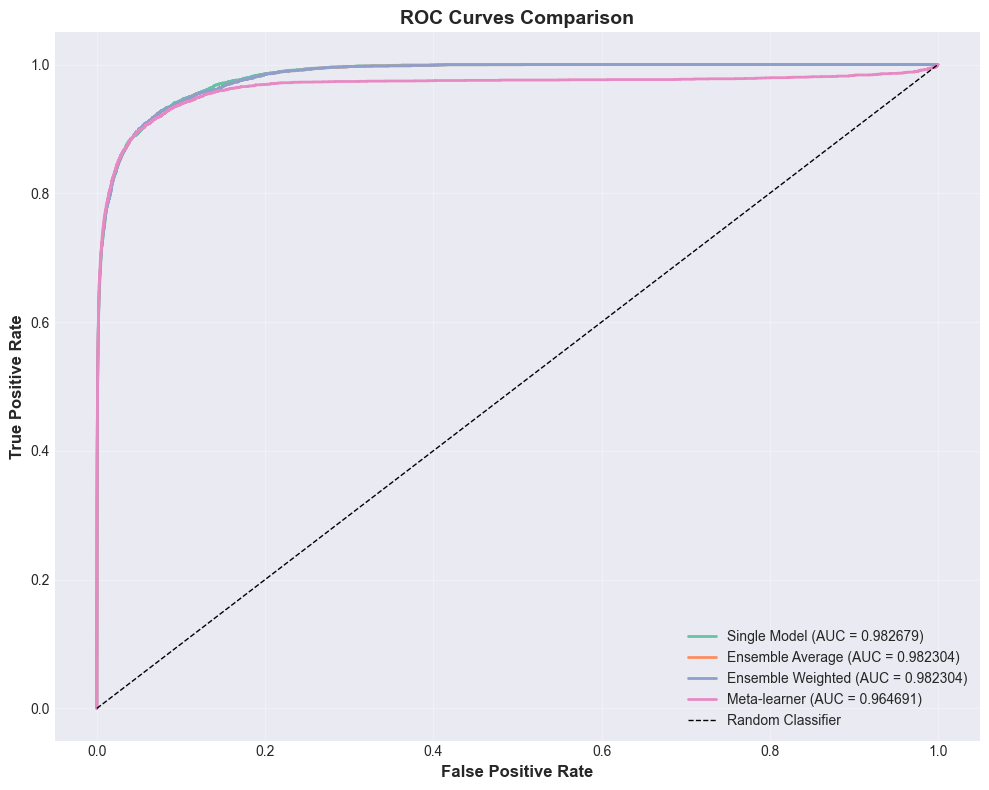

In [15]:
# Compare ROC curves
from sklearn.metrics import roc_curve, auc

baseline_pred = baseline_model.predict(X_val)

fig, ax = plt.subplots(figsize=(10, 8))

# Baseline
fpr, tpr, _ = roc_curve(y_val, baseline_pred)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, linewidth=2, label=f'Single Model (AUC = {roc_auc:.6f})')

# Ensemble average
fpr, tpr, _ = roc_curve(y_val, ensemble_val_pred_avg)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, linewidth=2, label=f'Ensemble Average (AUC = {roc_auc:.6f})')

# Ensemble weighted
fpr, tpr, _ = roc_curve(y_val, ensemble_val_pred_weighted)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, linewidth=2, label=f'Ensemble Weighted (AUC = {roc_auc:.6f})')

# Meta-learner
fpr, tpr, _ = roc_curve(y_val, ensemble_val_pred_meta)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, linewidth=2, label=f'Meta-learner (AUC = {roc_auc:.6f})')

# Diagonal
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')

ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('ROC Curves Comparison', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 15. Prediction Distribution Analysis

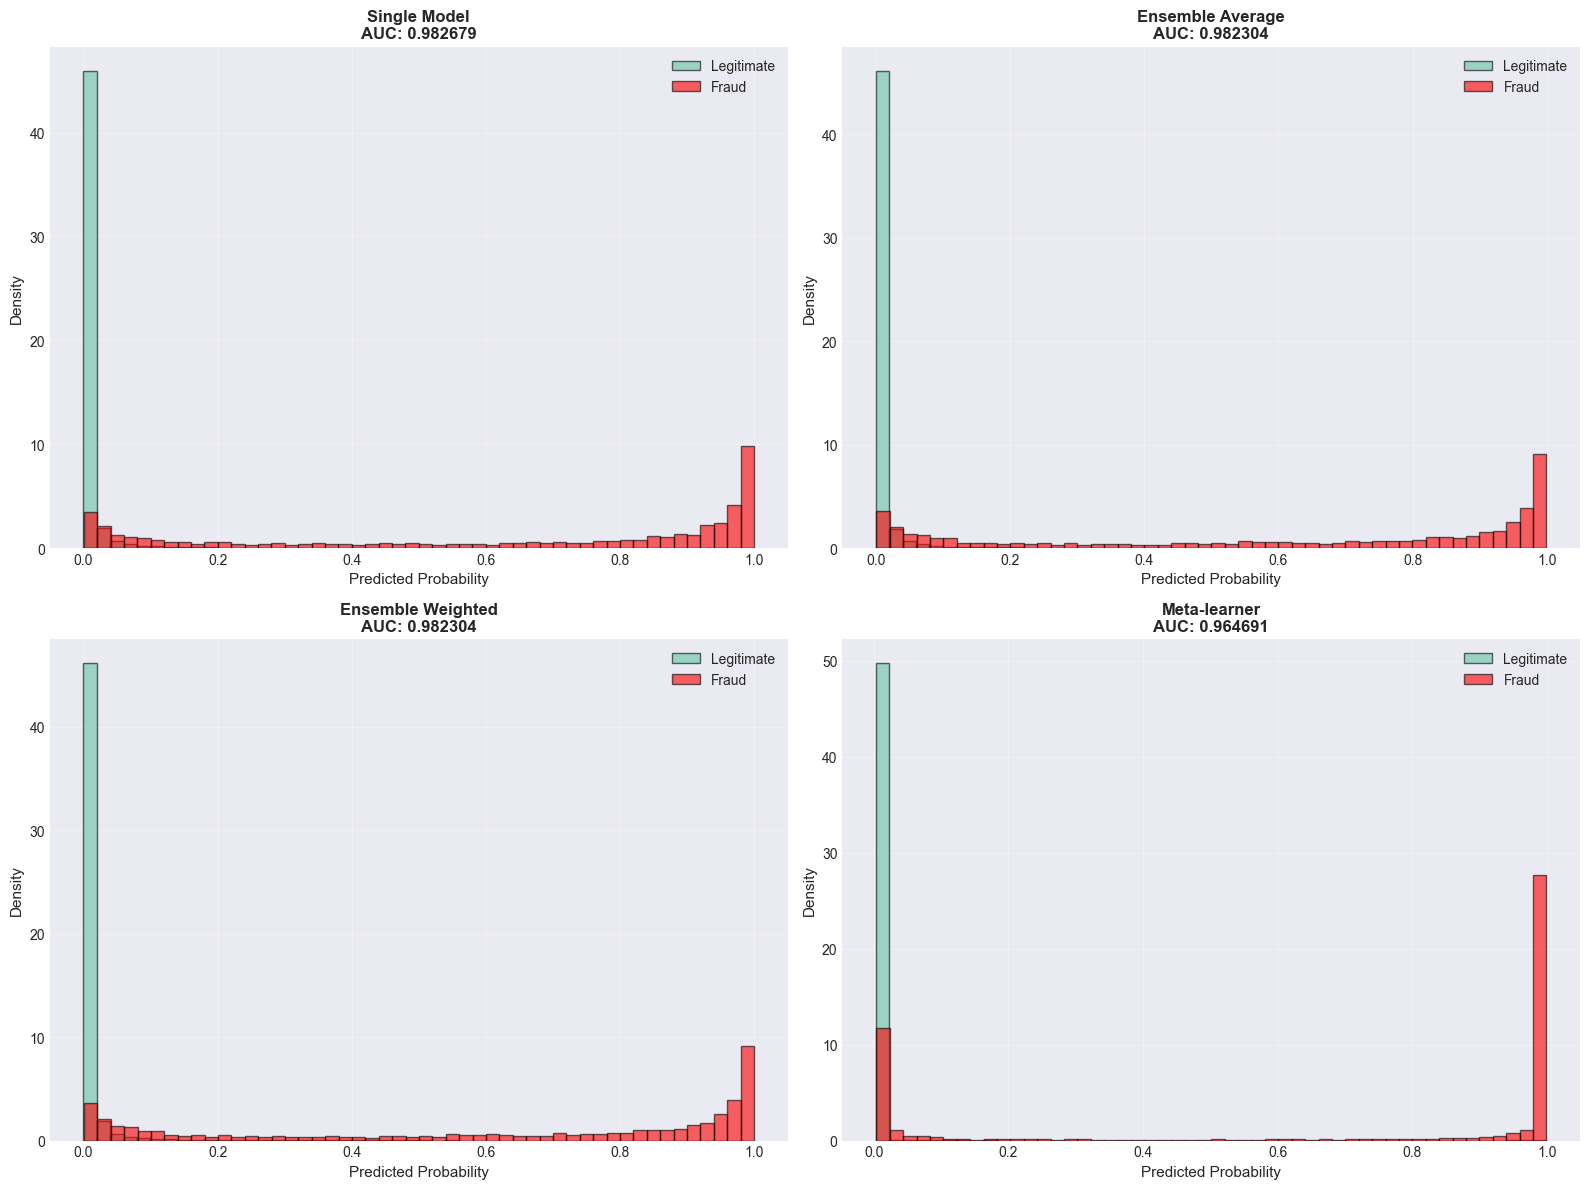

In [16]:
# Analyze prediction distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

predictions = {
    'Single Model': baseline_pred,
    'Ensemble Average': ensemble_val_pred_avg,
    'Ensemble Weighted': ensemble_val_pred_weighted,
    'Meta-learner': ensemble_val_pred_meta
}

for idx, (name, pred) in enumerate(predictions.items()):
    ax = axes[idx // 2, idx % 2]
    
    # Plot distributions by fraud status
    ax.hist(pred[y_val == 0], bins=50, alpha=0.6, label='Legitimate', edgecolor='black', density=True)
    ax.hist(pred[y_val == 1], bins=50, alpha=0.6, label='Fraud', color='red', edgecolor='black', density=True)
    
    ax.set_xlabel('Predicted Probability', fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title(f'{name}\nAUC: {roc_auc_score(y_val, pred):.6f}', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 16. Save Best Ensemble Model

In [17]:
# Determine best approach
best_method = 'average'
best_ensemble_auc = auc_avg

if auc_weighted > best_ensemble_auc:
    best_method = 'weighted'
    best_ensemble_auc = auc_weighted

if auc_meta > best_ensemble_auc:
    best_method = 'meta'
    best_ensemble_auc = auc_meta

print(f"Best ensemble method: {best_method}")
print(f"Best ensemble AUC: {best_ensemble_auc:.6f}")

# Save ensemble configuration
os.makedirs('../models', exist_ok=True)

ensemble_config = {
    'method': best_method,
    'validation_auc': float(best_ensemble_auc),
    'improvement_over_single': float(best_ensemble_auc - baseline_auc),
    'models': [m['name'] for m in ensemble.base_models],
    'weights': [float(w) for w in ensemble.weights] if ensemble.weights is not None else None,
    'n_folds': 5
}

with open('../models/ensemble_config.json', 'w') as f:
    json.dump(ensemble_config, f, indent=4)

print("\n✓ Ensemble configuration saved!")
print(f"  Method: {best_method}")
print(f"  Models: {len(ensemble.base_models)}")
print(f"  AUC: {best_ensemble_auc:.6f}")

Best ensemble method: average
Best ensemble AUC: 0.982304

✓ Ensemble configuration saved!
  Method: average
  Models: 5
  AUC: 0.982304


## 17. Summary

In [18]:
print("="*70)
print("MILESTONE 13: ENSEMBLE MODELING - COMPLETE")
print("="*70)

print("\n🎯 ENSEMBLE RESULTS:")
print(f"  • Single model baseline:             {baseline_auc:.6f}")
print(f"  • Ensemble (simple average):         {auc_avg:.6f}  (+{auc_avg - baseline_auc:.6f})")
print(f"  • Ensemble (optimized weights):      {auc_weighted:.6f}  (+{auc_weighted - baseline_auc:.6f})")
print(f"  • Ensemble (meta-learner):           {auc_meta:.6f}  (+{auc_meta - baseline_auc:.6f})")
print(f"  • Best ensemble improvement:         +{max(auc_avg, auc_weighted, auc_meta) - baseline_auc:.6f}")

print("\n📊 ENSEMBLE CONFIGURATION:")
print(f"  • Number of base models:             {len(ensemble.base_models)}")
print(f"  • Models: {', '.join([m['name'] for m in ensemble.base_models])}")
print(f"  • Stacking folds:                    5")
print(f"  • Best method:                       {best_method}")

if ensemble.weights is not None:
    print("\n🔧 OPTIMAL WEIGHTS:")
    for i, model_config in enumerate(ensemble.base_models):
        print(f"  • {model_config['name']:15s} {ensemble.weights[i]:.3f}")

print("\n🎯 PROGRESS TO TARGET:")
print(f"  • Current best AUC:                  {best_ensemble_auc:.6f}")
print(f"  • Target (Top 10%):                  0.945000")
print(f"  • Gap remaining:                     {0.945 - best_ensemble_auc:.6f}")
print(f"  • Total improvement from M10:        +{best_ensemble_auc - baseline_auc:.6f}")

print("\n✅ MILESTONES 11-13 COMPLETE")

print("\n📈 FULL PIPELINE SUMMARY:")
print("  • M7: Aggregation features")
print("  • M8: Interaction features")
print("  • M9: Temporal features")
print("  • M10: Missing value features")
print("  • M11: Hyperparameter tuning")
print("  • M12: Feature selection")
print("  • M13: Ensemble modeling")

print("\n🚀 NEXT STEPS (Final Submission):")
print("  • M14: Cross-validation refinement")
print("  • M15: Test set predictions")
print("  • M16: Competition submission")
print("  • Continue optimizing ensemble for 0.945+ target")

print("\n" + "="*70)
print("✓ ENSEMBLE MODELING COMPLETE")
print("="*70)

MILESTONE 13: ENSEMBLE MODELING - COMPLETE

🎯 ENSEMBLE RESULTS:
  • Single model baseline:             0.982679
  • Ensemble (simple average):         0.982304  (+-0.000374)
  • Ensemble (optimized weights):      0.982304  (+-0.000374)
  • Ensemble (meta-learner):           0.964691  (+-0.017988)
  • Best ensemble improvement:         +-0.000374

📊 ENSEMBLE CONFIGURATION:
  • Number of base models:             5
  • Models: LightGBM_1, LightGBM_2, LightGBM_3, XGBoost, CatBoost
  • Stacking folds:                    5
  • Best method:                       average

🔧 OPTIMAL WEIGHTS:
  • LightGBM_1      0.200
  • LightGBM_2      0.200
  • LightGBM_3      0.200
  • XGBoost         0.200
  • CatBoost        0.200

🎯 PROGRESS TO TARGET:
  • Current best AUC:                  0.982304
  • Target (Top 10%):                  0.945000
  • Gap remaining:                     -0.037304
  • Total improvement from M10:        +-0.000374

✅ MILESTONES 11-13 COMPLETE

📈 FULL PIPELINE SUMMARY:
  • M7: